In [124]:
import sys
sys.path.insert(0, '/home/ektov-av/python35-libs/lib/python3.5/site-packages/') 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import calendar
import time
import os
import joblib
import warnings
    
from sklearn.preprocessing import LabelEncoder, binarize

warnings.filterwarnings('ignore')

# from support_library.plot_support import *
pd.set_option('display.max_columns', None)

%matplotlib inline
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [125]:
def add_months(date, months):
    month = date.month - 1 + months
    year = date.year + month // 12
    month = month % 12 + 1
    day = min(date.day, calendar.monthrange(year, month)[1])
    return datetime.date(year, month, day)

In [126]:
def get_path(folder, file):
    return os.path.join(folder, file)

In [127]:
folder='data_csv/deal'
postfix='_mmb' #'_mmb'

## Assign FLAG to a specified value depending on the problem kind:
### -- set to 'test/train' if we want to generate a dataset with target variable  
### -- set to 'validate' if we gonna check a prediction on the validation dataset

In [128]:
FLAG='validate' # 'test/train'

## Fetching Main-Mart Database

In [129]:
df_columns_dict={}

In [130]:
if FLAG == 'test/train':
    df_kp_deal = pd.read_csv(get_path(folder, 'cvm_kp_deal_upd' + postfix + '.csv'), sep=';', 
                                                             compression='gzip', encoding='cp1251')
elif FLAG == 'validate':
    df_kp_deal = pd.read_csv(get_path(folder, 'cvm_vw_kp_deal' + '.csv'), sep=';', 
                                                             compression='gzip', encoding='cp1251')

In [131]:
# df_kp_deal = df_kp_deal.rename(columns={'Unnamed: 0': 'IS_SOLD'})
df_kp_deal.columns = df_kp_deal.columns.map(lambda x: x.lower())
df_kp_deal.loc[:, 'date_create'] = pd.to_datetime(df_kp_deal['date_create'], format='%Y-%m-%d')
df_kp_deal.loc[:, 'date_close']  = pd.to_datetime(df_kp_deal['date_close'], format='%Y-%m-%d')
df_kp_deal.head()

,id,vko_id,company_id,inn,tb,gosb,type_object,ckp_id,ckp,product,product_group,year_n,month_n,date_create,date_close,days_cr_q_end,segment_client,priority_client
0,1-HRZWSZV,1-VGWG-54,1-GMYS62M,6901027383,Московский банк,Московский банк,Deal,ЦА-ПБ-МТЭ-ММБ-0717,ЦА-ПБ-МТЭ-ММБ,E-invoicing,ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ,2017,7,2017-07-04,NaT,88,Малые,Нет
1,1-HYGZR8D,1-NO6P56Y,1-15MK1QJ,503412760320,Среднерусский банк,Западное ГОСБ №1025,Deal,ЦА-ПБ-ЮГР-ММБП-0717,ЦА-ПБ-ЮГР-ММБП,E-invoicing,ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ,2017,7,2017-07-17,NaT,75,Микро,Нет
2,1-HYLYLPF,1-13P42-9,1-2P8BQIT,7204029441,Западно-Сибирский банк,Тюменское ГОСБ №0029,Deal,ЦА-ПБ-ЮГР-ММБП-0717,ЦА-ПБ-ЮГР-ММБП,E-invoicing,ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ,2017,7,2017-07-17,NaT,75,Микро,Нет
3,1-I6BIKBZ,1-RCIAAPQ,1-47ZHDH,6209002522,Среднерусский банк,Рязанское ГОСБ №8606,Deal,ЦА-ПАССИВММБ4-0717,ЦА-ПАССИВММБ4,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,2017,8,2017-08-01,NaT,60,Малые,Нет
4,1-I93W8LT,1-5MO0-2,1-6TU19Z2,720606888308,Западно-Сибирский банк,Тюменское ГОСБ №0029,Deal,ЦА-ПРИВЛКЦ21-0817,ЦА-ПРИВЛКЦ21,Страхование НС,СТРАХОВАНИЕ,2017,8,2017-08-04,NaT,57,Микро,Ключевой


In [132]:
df_kp_deal.duplicated(subset=['inn', 'id']).sum()
#df_kp_deal = df_kp_deal.drop_duplicates()

0

In [133]:
df_kp_deal.shape

(19860, 18)

In [134]:
data=df_kp_deal

In [135]:
if FLAG == 'test/train':
    ckp_filter = data[(data['year_n']==2018) & (data['month_n']>0) & (data['ckp']=='ЦА-КРЕДСМАРТ')]
    pr_gr = pd.concat([pd.DataFrame(ckp_filter.groupby(['ckp','year_n', 'month_n'])['is_sold'].count())
                      ,pd.DataFrame(ckp_filter[ckp_filter['is_sold']==1].groupby(['ckp','year_n', 'month_n'])['is_sold'].count())
                      ,pd.DataFrame(ckp_filter[ckp_filter['is_sold']==0].groupby(['ckp','year_n', 'month_n'])['is_sold'].count())
                      ,], axis=1)
    pr_gr.columns=['TOTAL', '1', '0']
    pr_gr.head(20)

In [136]:
if FLAG == 'test/train':    
    balance = pd.concat([df_kp_deal.groupby('product_group')['is_sold'].sum(), 
                         df_kp_deal.groupby('product_group')['is_sold'].count()], axis=1)
    balance.columns = ['Sum of sold', 'Count']
    balance['balance'] = balance['Sum of sold'] / balance['Count']*100
    balance = balance.sort_values('balance', ascending=False)
    balance

In [137]:
if FLAG == 'test/train':
    df_temp = df_kp_deal[['date_create', 'is_sold']]
    df_temp = df_temp.set_index('date_create')
    df_temp.groupby(pd.Grouper(freq='M'))['is_sold'].count().sort_index().plot(kind='bar', color='orange', figsize=(10,8))

In [138]:
df_columns_dict['df_kp_deal']=df_kp_deal.columns.tolist()

## Working with Client Managers' database. Historic Data over CM

In [139]:
df_kp_km = pd.read_csv(get_path(folder, 'cvm_kp_km_upd' + postfix + '.csv'), sep=';', 
                                                         compression='gzip', encoding='cp1251')

In [140]:
# df_kp_km = df_kp_km.rename(columns={'Unnamed: 0': 'MONTH_'})
df_kp_km.columns = df_kp_km.columns.map(lambda x: x.lower())
df_kp_km.loc[:, 'month_'] = pd.to_datetime(df_kp_km['month_'], format='%Y-%m-%d')
df_kp_km = df_kp_km.drop(['year_n', 'month_n'], axis = 1)
df_kp_km.head()

,month_,vko_id,product,product_group,sum_sold,sum_sold_cumulate,sum_refused,sum_refused_cumulate,sum_sold_total,sum_sold_total_cumulate,sum_refused_total,sum_refused_tota_cumulate
0,2017-08-01,1-PJKWLOW,Сбербанк Бизнес Онлайн (СББОЛ),РКО,0,0,0,0,0.0,0.0,0.0,0.0
1,2017-08-01,1-71X2-22,Стабильный бизнес,СТРАХОВАНИЕ,0,0,0,0,5.0,11.0,1.0,0.0
2,2017-08-01,1-14T7V-11,Открытие банковского счета без договора-констр...,РКО,0,0,0,0,0.0,2.0,1.0,0.0
3,2017-08-01,1-QC-26,2216/Бизнес-инвест,КРЕДИТОВАНИЕ,0,0,0,0,3.0,0.0,1.0,0.0
4,2017-08-01,1-17Q5S-13,Открытие банковского счета без договора-констр...,РКО,0,0,0,0,1.0,2.0,0.0,0.0


In [141]:
df_kp_km.sort_values('month_').groupby(['month_']).sum()

,sum_sold,sum_sold_cumulate,sum_refused,sum_refused_cumulate,sum_sold_total,sum_sold_total_cumulate,sum_refused_total,sum_refused_tota_cumulate
month_,,,,,,,,
2017-08-01,8797,10716,1981,1373,195098.0,229114.0,44056.0,30734.0
2017-09-01,11208,19513,2993,3354,246960.0,424212.0,66595.0,74790.0
2017-10-01,12215,30721,3792,6347,269596.0,671172.0,84208.0,141385.0
2017-11-01,13314,42936,4365,10139,296460.0,940768.0,99374.0,225593.0
2017-12-01,19751,56250,5982,14504,445551.0,1237228.0,134758.0,324967.0
2018-01-01,11492,76001,4017,20486,261493.0,1682779.0,92097.0,459725.0
2018-02-01,12087,87493,4532,24503,273839.0,1944272.0,102441.0,551822.0
2018-03-01,14324,99580,6013,29035,323751.0,2218111.0,134913.0,654263.0
2018-04-01,17601,113904,6971,35048,400152.0,2541862.0,156906.0,789176.0


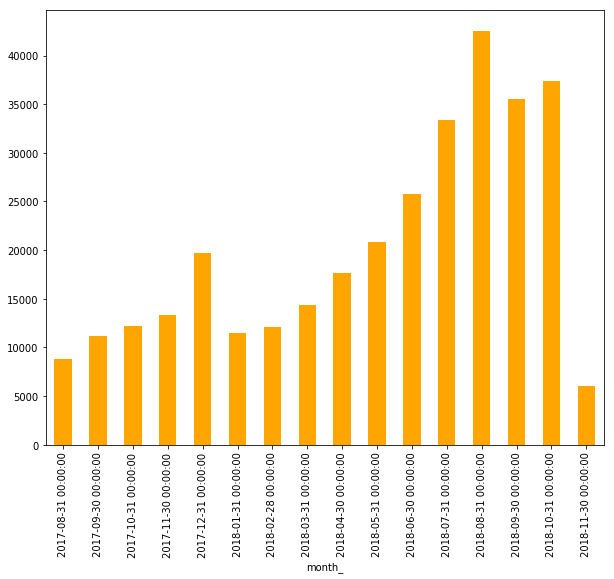

In [142]:
df_temp = df_kp_km[['month_', 'sum_sold']]
df_temp = df_temp.set_index('month_')
df_temp.groupby(pd.Grouper(freq='M'))['sum_sold'].sum().sort_index().plot(kind='bar', color='orange', figsize=(10,8))

In [143]:
df_kp_km.isnull().sum()

month_                         0
vko_id                       160
product                        0
product_group                  0
sum_sold                       0
sum_sold_cumulate              0
sum_refused                    0
sum_refused_cumulate           0
sum_sold_total               160
sum_sold_total_cumulate      160
sum_refused_total            160
sum_refused_tota_cumulate    160
dtype: int64

In [144]:
df_kp_km.shape

(1170704, 12)

In [145]:
df_kp_km = df_kp_km[~df_kp_km['vko_id'].isnull()]

In [146]:
df_kp_km=df_kp_km.drop_duplicates()

In [147]:
df_kp_km.shape

(1170544, 12)

In [148]:
df_columns_dict['df_kp_deal']=df_kp_deal.columns.tolist()

## Treatment of Historic Data over Companies

In [149]:
df_kp_company = pd.read_csv(get_path(folder, 'cvm_kp_company_upd' + postfix + '.csv'), sep=';', 
                                                         compression='gzip', encoding='cp1251')

In [150]:
df_kp_company.shape

(6135408, 14)

In [151]:
# df_kp_company=df_kp_company.rename(columns={'Unnamed: 0': 'MONTH_'})
df_kp_company.columns = df_kp_company.columns.map(lambda x: x.lower())
df_kp_company = df_kp_company.drop(['year_n', 'month_n'], axis = 1)
df_kp_company.loc[:, 'month_'] = pd.to_datetime(df_kp_company['month_'], format='%Y-%m-%d')
df_kp_company.head()

,month_,company_id,product,product_group,sum_sold,sum_sold_cumulate,sum_refused,sum_refused_cumulate,sum_sold_total,sum_sold_total_cumulate,sum_refused_total,sum_refused_total_cumulate
0,2018-06-01,1-EWRWSE,Зарплатные проекты,ЗАРПЛАТНЫЕ ПРОЕКТЫ,0,1,0,0,0,1,0,0
1,2018-06-01,1-E4ZY6M,Кредитная бизнес-карта,КРЕДИТНАЯ БИЗНЕС-КАРТА,0,1,0,0,0,1,0,0
2,2018-06-01,1-3X9D8TT,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,0,0,0,0,0,0,0,0
3,2018-06-01,1-14VM4P1,1948/Доверие,КРЕДИТОВАНИЕ,0,1,0,0,0,1,0,0
4,2018-06-01,1-14EYQB2,Зарплатные проекты,ЗАРПЛАТНЫЕ ПРОЕКТЫ,0,0,0,0,0,0,0,0


In [152]:
df_kp_company.sort_values('month_').groupby(['month_']).sum()

,sum_sold,sum_sold_cumulate,sum_refused,sum_refused_cumulate,sum_sold_total,sum_sold_total_cumulate,sum_refused_total,sum_refused_total_cumulate
month_,,,,,,,,
2017-08-01,8797,10716,1981,1373,25482,20610,4120,2293
2017-09-01,11208,19513,2993,3354,34888,46092,6892,6413
2017-10-01,12215,30721,3792,6347,38326,80980,9351,13305
2017-11-01,13314,42936,4365,10139,46005,119306,10296,22656
2017-12-01,19751,56250,5982,14504,75217,165311,15017,32952
2018-01-01,11492,76001,4017,20486,46210,240528,10462,47969
2018-02-01,12087,87493,4532,24503,43348,286738,10649,58431
2018-03-01,14324,99580,6013,29035,48880,330086,12414,69080
2018-04-01,17601,113904,6971,35048,64387,378966,15271,81494


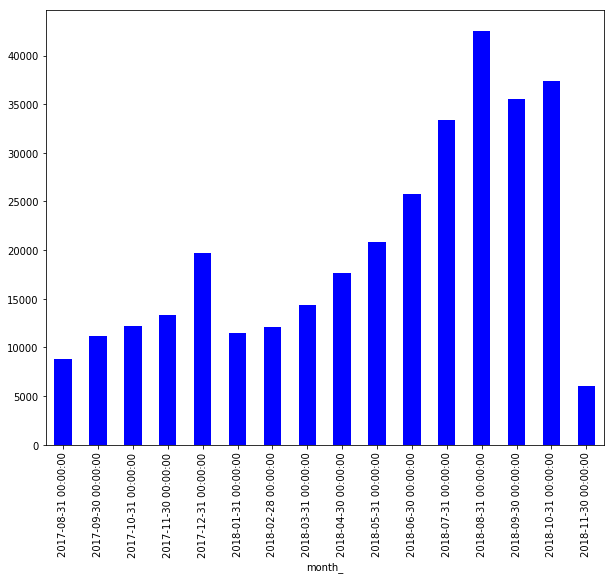

In [153]:
df_temp = df_kp_company[['month_', 'sum_sold']]
df_temp = df_temp.set_index('month_')
df_temp.groupby(pd.Grouper(freq='M'))['sum_sold'].sum().sort_index().plot(kind='bar', color='blue', figsize=(10,8))

In [154]:
df_kp_company.isnull().sum()

month_                        0
company_id                    0
product                       0
product_group                 0
sum_sold                      0
sum_sold_cumulate             0
sum_refused                   0
sum_refused_cumulate          0
sum_sold_total                0
sum_sold_total_cumulate       0
sum_refused_total             0
sum_refused_total_cumulate    0
dtype: int64

In [155]:
df_kp_company.shape

(6135408, 12)

In [156]:
df_kp_company=df_kp_company.drop_duplicates()

In [157]:
df_kp_company.shape

(6135185, 12)

In [158]:
df_kp_company.duplicated(subset=['month_', 'company_id', 'product']).sum()

49

In [159]:
df_columns_dict['df_kp_company']=df_kp_company.columns.tolist()

## Aggregates

In [160]:
df_kp_km_aggregates = df_kp_km.groupby(['vko_id', 'month_', 'product_group']).sum().reset_index()
df_kp_km_aggregates.head()

,vko_id,month_,product_group,sum_sold,sum_sold_cumulate,sum_refused,sum_refused_cumulate,sum_sold_total,sum_sold_total_cumulate,sum_refused_total,sum_refused_tota_cumulate
0,1-102GO-15,2017-08-01,БАНКОВСКАЯ ГАРАНТИЯ,0,0,0,0,32.0,10.0,0.0,0.0
1,1-102GO-15,2017-08-01,БИЗНЕС-КАРТА,0,0,0,0,16.0,5.0,0.0,0.0
2,1-102GO-15,2017-08-01,ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ,0,0,0,0,16.0,5.0,0.0,0.0
3,1-102GO-15,2017-08-01,ЗАРПЛАТНЫЕ ПРОЕКТЫ,0,0,0,0,16.0,5.0,0.0,0.0
4,1-102GO-15,2017-08-01,ИНКАССАЦИЯ,0,0,0,0,16.0,5.0,0.0,0.0


In [161]:
df_kp_company_aggregates = df_kp_company.groupby(['company_id', 'month_', 'product_group']).sum().reset_index()

In [162]:
df_columns_dict['df_kp_km_aggregates']=df_kp_km_aggregates.columns.tolist()
df_columns_dict['df_kp_company_aggregates']=df_kp_company_aggregates.columns.tolist()

## Aggregating statistics for Products being sold by CM

In [163]:
df_kp_share_prod = pd.read_csv(get_path(folder, 'cvm_kp_km_share_prod_upd' + '.csv'), sep=';', 
                                                         compression='gzip', encoding='cp1251')

In [164]:
# df_kp_share_prod=df_kp_share_prod.rename(columns={'Unnamed: 0': 'MONTH_'})
df_kp_share_prod.columns = df_kp_share_prod.columns.map(lambda x: x.lower())
df_kp_share_prod = df_kp_share_prod.drop(['year_n', 'month_n'], axis = 1)
df_kp_share_prod.loc[:, 'month_'] = pd.to_datetime(df_kp_share_prod['month_'], format='%Y-%m-%d')
df_kp_share_prod.head()

,month_,total_client_cnt,vko_id,oborot_kredit,invest_kredit,overdraft_kredit,proekt_finans,products_lizing,obsluzh_rts_rur,obsluzh_rts_val,spec_acc,deposit,veksel,deposit_sertificat,inkass,samoinkass,zarplat_projects,acquiring_torg,acquiring_mobile,acreditiv,valuta_control,garantee_kontract,garantee_gos,garantee_other,arenda_seyf,dbo,corporate_cards,cash_management,bank_straxovanie_imush,bank_straxovanie_lich,bank_straxovanie_otvet,obsluzh_beneficiar,einvoicing,factoring,priem_platezh,konversion,ns_servis,ns_terminal,work_sreda,ns_sait,ns_garant,pfi,dcd
0,2017-08-01,139.0,1-53ON-16,9.0,3.0,8.0,2.0,1.0,121.0,1.0,NaN,10.0,1.0,NaN,23.0,17.0,79.0,56.0,NaN,4.0,8.0,4.0,NaN,NaN,1.0,133.0,9.0,10.0,12.0,1.0,1.0,NaN,31.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-01,93.0,1-3JW-65,NaN,3.0,1.0,2.0,NaN,73.0,3.0,1.0,NaN,1.0,NaN,2.0,3.0,58.0,13.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,84.0,2.0,48.0,4.0,1.0,2.0,NaN,13.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-01,154.0,1-JK6M-24,26.0,1.0,NaN,NaN,1.0,139.0,3.0,NaN,13.0,NaN,NaN,3.0,30.0,61.0,39.0,NaN,1.0,14.0,2.0,NaN,NaN,NaN,140.0,37.0,NaN,10.0,10.0,NaN,NaN,31.0,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,2017-08-01,2.0,1-YW-3,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-01,22.0,1-GETO-24,3.0,NaN,NaN,NaN,NaN,20.0,2.0,1.0,NaN,1.0,NaN,NaN,3.0,4.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,1.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
df_kp_share_prod.groupby(['month_']).sum()

,total_client_cnt,oborot_kredit,invest_kredit,overdraft_kredit,proekt_finans,products_lizing,obsluzh_rts_rur,obsluzh_rts_val,spec_acc,deposit,veksel,deposit_sertificat,inkass,samoinkass,zarplat_projects,acquiring_torg,acquiring_mobile,acreditiv,valuta_control,garantee_kontract,garantee_gos,garantee_other,arenda_seyf,dbo,corporate_cards,cash_management,bank_straxovanie_imush,bank_straxovanie_lich,bank_straxovanie_otvet,obsluzh_beneficiar,einvoicing,factoring,priem_platezh,konversion,ns_servis,ns_terminal,work_sreda,ns_sait,ns_garant,pfi,dcd
month_,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-01,1901198.0,142045.0,3970.0,7030.0,1097.0,6529.0,1411025.0,33351.0,13584.0,44500.0,4345.0,39.0,22250.0,282907.0,464542.0,393747.0,6076.0,1754.0,62245.0,5575.0,66.0,1530.0,505.0,1603906.0,369393.0,19612.0,45935.0,101142.0,558.0,0.0,184974.0,215.0,0.0,20545.0,413.0,6440.0,3817.0,0.0,0.0,0.0,0.0
2017-09-01,1917577.0,145205.0,3976.0,7511.0,1163.0,7708.0,1422973.0,33310.0,13784.0,37978.0,3802.0,32.0,21229.0,186464.0,477178.0,404206.0,6061.0,1544.0,57382.0,5923.0,63.0,1590.0,493.0,1613226.0,396337.0,20838.0,49368.0,109294.0,607.0,0.0,192534.0,229.0,0.0,21097.0,414.0,6813.0,3968.0,0.0,0.0,0.0,0.0
2017-10-01,1965255.0,145872.0,3895.0,7504.0,1173.0,7966.0,1477059.0,34894.0,14747.0,41153.0,4215.0,32.0,21035.0,248236.0,486828.0,411663.0,6183.0,1675.0,57967.0,6105.0,55.0,1578.0,484.0,1657961.0,385763.0,21016.0,48607.0,87944.0,660.0,0.0,179909.0,232.0,0.0,21363.0,418.0,7423.0,3817.0,0.0,0.0,0.0,0.0
2017-11-01,2015599.0,145562.0,3933.0,7527.0,1204.0,8575.0,1543228.0,36243.0,16152.0,43888.0,4699.0,31.0,21818.0,296125.0,496138.0,423211.0,6779.0,1766.0,64217.0,6332.0,48.0,1627.0,480.0,1698520.0,367726.0,21471.0,51805.0,101160.0,715.0,0.0,172800.0,246.0,0.0,20855.0,555.0,7715.0,0.0,0.0,0.0,0.0,0.0
2017-12-01,2041613.0,156514.0,12605.0,8719.0,1339.0,9281.0,1530455.0,33424.0,16201.0,45078.0,4445.0,29.0,21292.0,300845.0,516938.0,440037.0,7557.0,1676.0,65204.0,6566.0,42.0,1752.0,480.0,1747703.0,411300.0,24053.0,52969.0,113537.0,787.0,0.0,156722.0,246.0,0.0,22061.0,557.0,8223.0,0.0,1798.0,383.0,96.0,113.0
2018-01-01,2073340.0,158902.0,12762.0,9198.0,1432.0,9564.0,1582169.0,36812.0,17064.0,47660.0,4895.0,29.0,20712.0,305895.0,515673.0,444428.0,8791.0,1906.0,65368.0,6882.0,37.0,1807.0,484.0,1775885.0,410485.0,24117.0,54669.0,102556.0,826.0,0.0,153260.0,273.0,0.0,21067.0,741.0,8445.0,0.0,1904.0,405.0,148.0,158.0
2018-02-01,2056520.0,150116.0,12918.0,7955.0,1340.0,9664.0,1524526.0,34636.0,13425.0,41799.0,4014.0,26.0,19546.0,234636.0,512056.0,450231.0,7130.0,1376.0,57196.0,6601.0,28.0,1706.0,411.0,1790300.0,374578.0,24015.0,8877.0,24914.0,53.0,0.0,134679.0,267.0,0.0,16471.0,779.0,8625.0,0.0,2162.0,415.0,64.0,69.0
2018-03-01,2159453.0,159622.0,13504.0,9745.0,1430.0,10282.0,1602003.0,37039.0,14033.0,44959.0,4492.0,26.0,20496.0,309339.0,547773.0,471463.0,8565.0,1761.0,65089.0,6869.0,29.0,1816.0,436.0,1855773.0,438875.0,24443.0,48526.0,82667.0,670.0,0.0,139432.0,299.0,0.0,21038.0,780.0,8822.0,0.0,2338.0,437.0,103.0,108.0
2018-04-01,2198233.0,160364.0,14076.0,10047.0,1418.0,10766.0,1613757.0,33558.0,13438.0,31561.0,3776.0,25.0,20871.0,323228.0,558014.0,476966.0,7777.0,1816.0,66175.0,5862.0,13.0,1768.0,422.0,1899473.0,458408.0,24458.0,51667.0,85455.0,706.0,0.0,139819.0,308.0,0.0,21014.0,1078.0,8840.0,0.0,2534.0,462.0,149.0,120.0


In [166]:
df_kp_share_prod.groupby(['month_', 'vko_id']).sum().groupby(['month_']).sum()

,total_client_cnt,oborot_kredit,invest_kredit,overdraft_kredit,proekt_finans,products_lizing,obsluzh_rts_rur,obsluzh_rts_val,spec_acc,deposit,veksel,deposit_sertificat,inkass,samoinkass,zarplat_projects,acquiring_torg,acquiring_mobile,acreditiv,valuta_control,garantee_kontract,garantee_gos,garantee_other,arenda_seyf,dbo,corporate_cards,cash_management,bank_straxovanie_imush,bank_straxovanie_lich,bank_straxovanie_otvet,obsluzh_beneficiar,einvoicing,factoring,priem_platezh,konversion,ns_servis,ns_terminal,work_sreda,ns_sait,ns_garant,pfi,dcd
month_,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-01,1901198.0,141587.0,3963.0,7029.0,1096.0,6296.0,1407597.0,33066.0,13574.0,44466.0,4185.0,37.0,22206.0,282682.0,464070.0,365654.0,5511.0,1742.0,62129.0,5574.0,66.0,1529.0,493.0,1599174.0,369165.0,19508.0,45377.0,100248.0,535.0,0.0,184681.0,214.0,0.0,20412.0,413.0,6440.0,3790.0,0.0,0.0,0.0,0.0
2017-09-01,1917577.0,144761.0,3968.0,7511.0,1161.0,7444.0,1419471.0,33020.0,13764.0,37941.0,3685.0,31.0,21198.0,186384.0,476705.0,375257.0,5564.0,1535.0,57300.0,5921.0,63.0,1589.0,482.0,1608190.0,396041.0,20729.0,48755.0,108215.0,583.0,0.0,192263.0,228.0,0.0,20961.0,414.0,6813.0,3932.0,0.0,0.0,0.0,0.0
2017-10-01,1965255.0,145454.0,3890.0,7504.0,1172.0,7714.0,1473827.0,34616.0,14735.0,41122.0,4103.0,31.0,21007.0,248130.0,486351.0,383571.0,5715.0,1670.0,57888.0,6103.0,55.0,1577.0,474.0,1653356.0,385605.0,20904.0,48000.0,87006.0,634.0,0.0,179651.0,232.0,0.0,21224.0,418.0,7423.0,3790.0,0.0,0.0,0.0,0.0
2017-11-01,2015599.0,145160.0,3928.0,7526.0,1204.0,8336.0,1540044.0,36024.0,16125.0,43865.0,4607.0,30.0,21778.0,295922.0,495795.0,396324.0,6284.0,1759.0,64151.0,6330.0,48.0,1626.0,466.0,1693518.0,367599.0,21341.0,51207.0,99969.0,690.0,0.0,172500.0,246.0,0.0,20763.0,555.0,7715.0,0.0,0.0,0.0,0.0,0.0
2017-12-01,2041613.0,156130.0,12366.0,8718.0,1338.0,9030.0,1527266.0,33182.0,16170.0,45043.0,4355.0,28.0,21268.0,300601.0,516610.0,413318.0,7030.0,1665.0,65149.0,6565.0,42.0,1751.0,476.0,1742976.0,411175.0,23926.0,52347.0,112090.0,762.0,0.0,156684.0,246.0,0.0,21939.0,557.0,8223.0,0.0,1798.0,383.0,96.0,113.0
2018-01-01,2073340.0,158502.0,12539.0,9197.0,1431.0,9325.0,1579047.0,36566.0,17049.0,47622.0,4799.0,28.0,20710.0,305714.0,515362.0,417816.0,8165.0,1896.0,65311.0,6881.0,37.0,1806.0,480.0,1771271.0,410369.0,23984.0,54050.0,101071.0,802.0,0.0,153228.0,273.0,0.0,20950.0,741.0,8445.0,0.0,1904.0,405.0,148.0,158.0
2018-02-01,2056520.0,149788.0,12907.0,7955.0,1340.0,9644.0,1522172.0,34405.0,13422.0,41779.0,3972.0,25.0,19530.0,234535.0,511761.0,423594.0,6678.0,1369.0,57167.0,6600.0,28.0,1705.0,407.0,1787537.0,374541.0,23886.0,8817.0,24798.0,52.0,0.0,134668.0,267.0,0.0,16411.0,779.0,8625.0,0.0,2162.0,415.0,64.0,69.0
2018-03-01,2159453.0,159273.0,13487.0,9744.0,1428.0,10239.0,1600304.0,36866.0,14031.0,44944.0,4430.0,25.0,20490.0,309267.0,547599.0,469625.0,8541.0,1756.0,65064.0,6867.0,29.0,1814.0,436.0,1853483.0,438849.0,24330.0,48216.0,81450.0,656.0,0.0,139421.0,299.0,0.0,21019.0,780.0,8822.0,0.0,2338.0,437.0,103.0,108.0
2018-04-01,2198233.0,160012.0,14028.0,10046.0,1418.0,10707.0,1612028.0,33389.0,13436.0,31554.0,3720.0,24.0,20861.0,323139.0,557844.0,474272.0,7755.0,1808.0,66150.0,5861.0,13.0,1767.0,422.0,1896982.0,458378.0,24342.0,51330.0,84227.0,690.0,0.0,139809.0,308.0,0.0,20993.0,1078.0,8840.0,0.0,2534.0,462.0,149.0,120.0


In [167]:
df_kp_share_prod.sort_values('month_').groupby('month_')['vko_id'].count()

month_
2017-08-01    8311
2017-09-01    8321
2017-10-01    8456
2017-11-01    8553
2017-12-01    8508
2018-01-01    8606
2018-02-01    8559
2018-03-01    8594
2018-04-01    8495
2018-05-01    8397
2018-06-01    8371
2018-07-01    8422
2018-08-01    8567
2018-09-01    8261
2018-10-01    8355
Name: vko_id, dtype: int64

In [168]:
df_kp_share_prod.duplicated(subset=['month_', 'vko_id']).sum()

0

In [169]:
df_kp_share_prod.shape

(126791, 43)

In [170]:
df_kp_share_prod.isnull().sum()

month_                         0
total_client_cnt              15
vko_id                        15
oborot_kredit              39328
invest_kredit              74041
overdraft_kredit           74402
proekt_finans             117637
products_lizing            70475
obsluzh_rts_rur            17734
obsluzh_rts_val            53440
spec_acc                   73440
deposit                    49277
veksel                     93268
deposit_sertificat        126394
inkass                     63465
samoinkass                 41518
zarplat_projects           35206
acquiring_torg             31081
acquiring_mobile           80786
acreditiv                 109348
valuta_control             46575
garantee_kontract          82496
garantee_gos              126397
garantee_other            110747
arenda_seyf               121018
dbo                         9891
corporate_cards            38363
cash_management            72756
bank_straxovanie_imush     50606
bank_straxovanie_lich      55697
bank_strax

In [171]:
for col in df_kp_share_prod.columns:
    if df_kp_share_prod[col].isnull().sum() == df_kp_share_prod.shape[0]:
        df_kp_share_prod.drop([col], axis = 1, inplace=True)
        print(col+' has been deleted')

obsluzh_beneficiar has been deleted
priem_platezh has been deleted


In [172]:
df_kp_share_prod = df_kp_share_prod[~df_kp_share_prod['total_client_cnt'].isnull()]

In [173]:
df_kp_share_prod.shape

(126776, 41)

In [174]:
for col in set(df_kp_share_prod.columns) - set(['month_', 'year_n', 'month_n', 'total_client_cnt', 'vko_id']):
    df_kp_share_prod[col + '_ratio'] = df_kp_share_prod[col] / df_kp_share_prod['total_client_cnt']

In [175]:
df_kp_share_prod.head()

,month_,total_client_cnt,vko_id,oborot_kredit,invest_kredit,overdraft_kredit,proekt_finans,products_lizing,obsluzh_rts_rur,obsluzh_rts_val,spec_acc,deposit,veksel,deposit_sertificat,inkass,samoinkass,zarplat_projects,acquiring_torg,acquiring_mobile,acreditiv,valuta_control,garantee_kontract,garantee_gos,garantee_other,arenda_seyf,dbo,corporate_cards,cash_management,bank_straxovanie_imush,bank_straxovanie_lich,bank_straxovanie_otvet,einvoicing,factoring,konversion,ns_servis,ns_terminal,work_sreda,ns_sait,ns_garant,pfi,dcd,spec_acc_ratio,bank_straxovanie_imush_ratio,ns_garant_ratio,obsluzh_rts_rur_ratio,obsluzh_rts_val_ratio,einvoicing_ratio,konversion_ratio,oborot_kredit_ratio,acquiring_torg_ratio,ns_servis_ratio,dcd_ratio,veksel_ratio,garantee_gos_ratio,bank_straxovanie_lich_ratio,overdraft_kredit_ratio,proekt_finans_ratio,products_lizing_ratio,bank_straxovanie_otvet_ratio,garantee_kontract_ratio,garantee_other_ratio,work_sreda_ratio,dbo_ratio,zarplat_projects_ratio,corporate_cards_ratio,ns_sait_ratio,ns_terminal_ratio,inkass_ratio,deposit_ratio,invest_kredit_ratio,samoinkass_ratio,valuta_control_ratio,pfi_ratio,factoring_ratio,acreditiv_ratio,deposit_sertificat_ratio,cash_management_ratio,arenda_seyf_ratio,acquiring_mobile_ratio
0,2017-08-01,139.0,1-53ON-16,9.0,3.0,8.0,2.0,1.0,121.0,1.0,NaN,10.0,1.0,NaN,23.0,17.0,79.0,56.0,NaN,4.0,8.0,4.0,NaN,NaN,1.0,133.0,9.0,10.0,12.0,1.0,1.0,31.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.086331,NaN,0.870504,0.007194,0.223022,0.014388,0.064748,0.402878,NaN,NaN,0.007194,NaN,0.007194,0.057554,0.014388,0.007194,0.007194,0.028777,NaN,NaN,0.956835,0.568345,0.064748,NaN,NaN,0.165468,0.071942,0.021583,0.122302,0.057554,NaN,NaN,0.028777,NaN,0.071942,0.007194,NaN
1,2017-08-01,93.0,1-3JW-65,NaN,3.0,1.0,2.0,NaN,73.0,3.0,1.0,NaN,1.0,NaN,2.0,3.0,58.0,13.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,84.0,2.0,48.0,4.0,1.0,2.0,13.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010753,0.043011,NaN,0.784946,0.032258,0.139785,0.032258,NaN,0.139785,NaN,NaN,0.010753,NaN,0.010753,0.010753,0.021505,NaN,0.021505,NaN,NaN,NaN,0.903226,0.623656,0.021505,NaN,NaN,0.021505,NaN,0.032258,0.032258,0.053763,NaN,NaN,NaN,NaN,0.516129,NaN,0.043011
2,2017-08-01,154.0,1-JK6M-24,26.0,1.0,NaN,NaN,1.0,139.0,3.0,NaN,13.0,NaN,NaN,3.0,30.0,61.0,39.0,NaN,1.0,14.0,2.0,NaN,NaN,NaN,140.0,37.0,NaN,10.0,10.0,NaN,31.0,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.064935,NaN,0.902597,0.019481,0.201299,0.012987,0.168831,0.253247,NaN,NaN,NaN,NaN,0.064935,NaN,NaN,0.006494,NaN,0.012987,NaN,NaN,0.909091,0.396104,0.240260,NaN,0.006494,0.019481,0.084416,0.006494,0.194805,0.090909,NaN,NaN,0.006494,NaN,NaN,NaN,NaN
3,2017-08-01,2.0,1-YW-3,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-01,22.0,1-GETO-24,3.0,NaN,NaN,NaN,NaN,20.0,2.0,1.0,NaN,1.0,NaN,NaN,3.0,4.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,1.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045455,NaN,NaN,0.909091,0.090909,0.181818,NaN,0.136364,0.136364,NaN,NaN,0.045455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.954545,0.181818,0.045455,NaN,NaN,NaN,NaN,NaN,0.136364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045455


In [176]:
df_columns_dict['df_kp_share_prod']=df_kp_share_prod.columns.tolist()

## Difference between current deal and previous one (by Companies)

In [177]:
df_comp_dealdiff = pd.read_csv(get_path(folder, 'cvm_kp_comp_dealdiff_upd'+ postfix +'.csv'), sep=';', 
                                                         compression='gzip', encoding='cp1251')

In [178]:
# df_comp_dealdiff = df_comp_dealdiff.rename(columns={'Unnamed: 0': 'company_id'})
df_comp_dealdiff.columns = df_comp_dealdiff.columns.map(lambda x: x.lower())
df_comp_dealdiff = df_comp_dealdiff.drop(['year_n', 'month_n'], axis = 1)
df_comp_dealdiff.loc[:, 'date_create'] = pd.to_datetime(df_comp_dealdiff['date_create'], format='%Y-%m-%d')
df_comp_dealdiff.head()

,company_id,date_create,days_between,is_previous_sold
0,1-28MP1RP,2018-10-02,40,0
1,1-28MP1RP,2018-08-23,153,0
2,1-28OIKJA,2018-06-09,22,0
3,1-28OIKJA,2018-05-18,72,1
4,1-28Q7JHA,2018-06-07,80,0


In [179]:
df_comp_dealdiff.drop_duplicates(inplace=True)

In [180]:
df_comp_dealdiff.shape

(74322, 4)

In [181]:
df_columns_dict['df_comp_dealdiff']=df_comp_dealdiff.columns.tolist()

## Difference between current deal and previous one (by CM)

In [182]:
df_km_dealdiff = pd.read_csv(get_path(folder, 'cvm_kp_km_dealdiff_upd'+ postfix +'.csv'), sep=';', 
                                                         compression='gzip', encoding='cp1251')

In [183]:
# df_km_dealdiff = df_km_dealdiff.rename(columns={'Unnamed: 0': 'vko_id'})
df_km_dealdiff.columns = df_km_dealdiff.columns.map(lambda x: x.lower())
df_km_dealdiff = df_km_dealdiff.drop(['year_n', 'month_n'], axis = 1)
df_km_dealdiff.loc[:, 'date_create'] = pd.to_datetime(df_km_dealdiff['date_create'], format='%Y-%m-%d')
df_km_dealdiff.head()

,vko_id,date_create,days_between,is_previous_sold
0,1-O1RWNL0,2018-05-10,2,0
1,1-O1RWNL0,2018-05-08,15,1
2,1-O1RWNL0,2018-04-23,3,0
3,1-O1RWNL0,2018-04-20,2,1
4,1-O1RWNL0,2018-04-09,10,1


In [184]:
df_km_dealdiff.drop_duplicates(inplace=True)

In [185]:
df_km_dealdiff.shape

(142502, 4)

In [186]:
df_km_dealdiff.columns.tolist()

['vko_id', 'date_create', 'days_between', 'is_previous_sold']

In [187]:
df_columns_dict['df_km_dealdiff']=df_km_dealdiff.columns.tolist()

In [188]:
df_columns_dict.keys()
joblib.dump(df_columns_dict, get_path('pkl_store', 'df_columns_dict.pkl'))

['pkl_store/df_columns_dict.pkl']

## Joining Databases with Aggregates on Main Mart Database

In [189]:
start_shape = df_kp_deal.shape[0]

In [190]:
df = df_kp_deal

In [191]:
df.shape

(19860, 18)

In [192]:
df['kp_prev_1'] = (pd.to_datetime({'day': 1, 'month': df['date_create'].dt.month, \
            'year': df['date_create'].dt.year}) - pd.offsets.MonthOffset(1))
df['kp_prev_2'] = (pd.to_datetime({'day': 1, 'month': df['date_create'].dt.month, \
            'year': df['date_create'].dt.year}) - pd.offsets.MonthOffset(2))
df['kp_prev_3'] = (pd.to_datetime({'day': 1, 'month': df['date_create'].dt.month, \
            'year': df['date_create'].dt.year}) - pd.offsets.MonthOffset(3))

In [193]:
df_kp_company.loc[df_kp_company.duplicated(['company_id', 'month_', 'product'], keep=False),:].sort_values(['company_id', 'month_', 'product'], ascending=True)

,month_,company_id,product,product_group,sum_sold,sum_sold_cumulate,sum_refused,sum_refused_cumulate,sum_sold_total,sum_sold_total_cumulate,sum_refused_total,sum_refused_total_cumulate
88111,2017-08-01,1-3FRY2MF,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,1,0,0,0,1,0,0,0
1059357,2017-08-01,1-3FRY2MF,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,0,0,0,0,1,0,0,0
2120438,2017-09-01,1-3FRY2MF,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,0,0,0,0,3,1,0,0
3457381,2017-09-01,1-3FRY2MF,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,1,1,0,0,3,1,0,0
2073969,2017-10-01,1-3FRY2MF,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,0,0,0,0,2,4,0,0
3646538,2017-10-01,1-3FRY2MF,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,1,2,0,0,2,4,0,0
1192568,2017-11-01,1-3FRY2MF,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,0,0,0,0,2,6,0,0
1366300,2017-11-01,1-3FRY2MF,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,1,3,0,0,2,6,0,0
3660976,2017-12-01,1-3FRY2MF,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,0,4,0,0,0,8,0,0
4376098,2017-12-01,1-3FRY2MF,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,0,0,0,0,0,8,0,0


In [194]:
df_kp_company.drop_duplicates(['company_id', 'month_', 'product'], keep=False, inplace=True)

In [195]:
for i in [1,2,3]:
    print('Roll back by %.d month' % i)
    df = df.merge(   df_kp_km, how='left', left_on=['vko_id', 'kp_prev_%.d' % i, 'product'], \
                     right_on=['vko_id', 'month_', 'product'], suffixes=('', '_km_shift_%.d' % i))
    count_kp_km = df.merge(df_kp_km, how='inner', left_on=['vko_id', 'kp_prev_%.d' % i, 'product'], \
             right_on=['vko_id', 'month_', 'product']).shape[0]
    
    print('CM: Databases intersection is equal to %.d rows' % (count_kp_km))
    
    df = df.merge(  df_kp_company, how='left', left_on=['company_id', 'kp_prev_%.d' % i, 'product'], \
                    right_on=['company_id', 'month_', 'product'], suffixes=('', '_company_shift_%.d' % i))
    count_kp_company = df.merge(df_kp_company, how='inner', left_on=['company_id', 'kp_prev_%.d' % i, 'product'], \
             right_on=['company_id', 'month_', 'product']).shape[0]
    
    print('COMPANIES: Databases intersection is equal to %.d rows' % (count_kp_company))

Roll back by 1 month
CM: Databases intersection is equal to 16640 rows
COMPANIES: Databases intersection is equal to 1535 rows
Roll back by 2 month
CM: Databases intersection is equal to 16616 rows
COMPANIES: Databases intersection is equal to 1529 rows
Roll back by 3 month
CM: Databases intersection is equal to 16593 rows
COMPANIES: Databases intersection is equal to 1525 rows


In [196]:
df.head()
#df[df['sum_sold'].isnull()].head()

,id,vko_id,company_id,inn,tb,gosb,type_object,ckp_id,ckp,product,product_group,year_n,month_n,date_create,date_close,days_cr_q_end,segment_client,priority_client,kp_prev_1,kp_prev_2,kp_prev_3,month_,product_group_km_shift_1,sum_sold,sum_sold_cumulate,sum_refused,sum_refused_cumulate,sum_sold_total,sum_sold_total_cumulate,sum_refused_total,sum_refused_tota_cumulate,month__company_shift_1,product_group_company_shift_1,sum_sold_company_shift_1,sum_sold_cumulate_company_shift_1,sum_refused_company_shift_1,sum_refused_cumulate_company_shift_1,sum_sold_total_company_shift_1,sum_sold_total_cumulate_company_shift_1,sum_refused_total_company_shift_1,sum_refused_total_cumulate,month__km_shift_2,product_group_km_shift_2,sum_sold_km_shift_2,sum_sold_cumulate_km_shift_2,sum_refused_km_shift_2,sum_refused_cumulate_km_shift_2,sum_sold_total_km_shift_2,sum_sold_total_cumulate_km_shift_2,sum_refused_total_km_shift_2,sum_refused_tota_cumulate_km_shift_2,month__company_shift_2,product_group_company_shift_2,sum_sold_company_shift_2,sum_sold_cumulate_company_shift_2,sum_refused_company_shift_2,sum_refused_cumulate_company_shift_2,sum_sold_total_company_shift_2,sum_sold_total_cumulate_company_shift_2,sum_refused_total_company_shift_2,sum_refused_total_cumulate_company_shift_2,month__km_shift_3,product_group_km_shift_3,sum_sold_km_shift_3,sum_sold_cumulate_km_shift_3,sum_refused_km_shift_3,sum_refused_cumulate_km_shift_3,sum_sold_total_km_shift_3,sum_sold_total_cumulate_km_shift_3,sum_refused_total_km_shift_3,sum_refused_tota_cumulate_km_shift_3,month__company_shift_3,product_group_company_shift_3,sum_sold_company_shift_3,sum_sold_cumulate_company_shift_3,sum_refused_company_shift_3,sum_refused_cumulate_company_shift_3,sum_sold_total_company_shift_3,sum_sold_total_cumulate_company_shift_3,sum_refused_total_company_shift_3,sum_refused_total_cumulate_company_shift_3
0,1-HRZWSZV,1-VGWG-54,1-GMYS62M,6901027383,Московский банк,Московский банк,Deal,ЦА-ПБ-МТЭ-ММБ-0717,ЦА-ПБ-МТЭ-ММБ,E-invoicing,ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ,2017,7,2017-07-04,NaT,88,Малые,Нет,2017-06-01,2017-05-01,2017-04-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1-HYGZR8D,1-NO6P56Y,1-15MK1QJ,503412760320,Среднерусский банк,Западное ГОСБ №1025,Deal,ЦА-ПБ-ЮГР-ММБП-0717,ЦА-ПБ-ЮГР-ММБП,E-invoicing,ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ,2017,7,2017-07-17,NaT,75,Микро,Нет,2017-06-01,2017-05-01,2017-04-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1-HYLYLPF,1-13P42-9,1-2P8BQIT,7204029441,Западно-Сибирский банк,Тюменское ГОСБ №0029,Deal,ЦА-ПБ-ЮГР-ММБП-0717,ЦА-ПБ-ЮГР-ММБП,E-invoicing,ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ,2017,7,2017-07-17,NaT,75,Микро,Нет,2017-06-01,2017-05-01,2017-04-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1-I6BIKBZ,1-RCIAAPQ,1-47ZHDH,6209002522,Среднерусский банк,Рязанское ГОСБ №8606,Deal,ЦА-ПАССИВММБ4-0717,ЦА-ПАССИВММБ4,Депозиты (срочные),ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ,2017,8,2017-08-01,NaT,60,Малые,Нет,2017-07-01,2017-06-01,2017-05-01,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1-I93W8LT,1-5MO0-2,1-6TU19Z2,720606888308,Западно-Сибирский банк,Тюменское ГОСБ №0029,Deal,ЦА-ПРИВЛКЦ21-0817,ЦА-ПРИВЛКЦ21,Страхование НС,СТРАХОВАНИЕ,2017,8,2017-08-04,NaT,57,Микро,Ключевой,2017-07-01,2017-06-01,2017-05-01,NaT,NaN,NaN,NaN,NaN,N

In [197]:
start_shape - df.shape[0]

0

In [198]:
len(set(df['company_id']) - set(df_kp_deal['company_id']))

0

## Joining Databases with aggregates

In [199]:
df_kp_company_aggregates.loc[df_kp_company_aggregates.duplicated(['company_id', 'month_', 'product_group'], keep=False),:].sort_values(['company_id', 'month_', 'product_group'], ascending=True)

,company_id,month_,product_group,sum_sold,sum_sold_cumulate,sum_refused,sum_refused_cumulate,sum_sold_total,sum_sold_total_cumulate,sum_refused_total,sum_refused_total_cumulate


In [200]:
for i in [1, 2, 3]:
    print('Roll back by %.d month' % i)
    df = df.merge(df_kp_km_aggregates, how='left', left_on=['vko_id', 'kp_prev_%.d' % i, 'product_group'], \
             right_on=['vko_id', 'month_', 'product_group'], suffixes=('', '_agg_km_shift_%.d' % i))
    count_kp_km = df.merge(df_kp_km_aggregates, how='inner', 
                             left_on =['vko_id', 'kp_prev_%.d' % i, 'product_group'], \
                             right_on=['vko_id', 'month_', 'product_group']).shape[0]
    print('CM: Databases intersection is equal to %.d rows' % (count_kp_km))
    
    df = df.merge(df_kp_company_aggregates, how='left', left_on=['company_id', 'kp_prev_%.d' % i, 'product_group'], \
             right_on=['company_id', 'month_', 'product_group'], suffixes=('', '_agg_company_shift_%.d' % i))
    count_kp_company = df.merge(df_kp_company_aggregates, how='inner', 
                                left_on=['company_id', 'kp_prev_%.d' % i, 'product_group'], \
                                right_on=['company_id', 'month_', 'product_group']).shape[0]
    print('COMPANY: Databases intersection is equal to %.d rows' % (count_kp_company))

Roll back by 1 month
CM: Databases intersection is equal to 18736 rows
COMPANY: Databases intersection is equal to 2569 rows
Roll back by 2 month
CM: Databases intersection is equal to 18710 rows
COMPANY: Databases intersection is equal to 2562 rows
Roll back by 3 month
CM: Databases intersection is equal to 18684 rows
COMPANY: Databases intersection is equal to 2558 rows


In [201]:
start_shape - df.shape[0]

0

In [202]:
df_kp_company_aggregates['month_'].sort_values().unique()

array(['2017-08-01T00:00:00.000000000', '2017-09-01T00:00:00.000000000',
       '2017-10-01T00:00:00.000000000', '2017-11-01T00:00:00.000000000',
       '2017-12-01T00:00:00.000000000', '2018-01-01T00:00:00.000000000',
       '2018-02-01T00:00:00.000000000', '2018-03-01T00:00:00.000000000',
       '2018-04-01T00:00:00.000000000', '2018-05-01T00:00:00.000000000',
       '2018-06-01T00:00:00.000000000', '2018-07-01T00:00:00.000000000',
       '2018-08-01T00:00:00.000000000', '2018-09-01T00:00:00.000000000',
       '2018-10-01T00:00:00.000000000', '2018-11-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

## Joining df_kp_share_prod Database

In [203]:
df_kp_share_prod.shape

(126776, 79)

In [204]:
df_kp_share_prod.duplicated().sum()

0

In [205]:
df_kp_share_prod.head()

,month_,total_client_cnt,vko_id,oborot_kredit,invest_kredit,overdraft_kredit,proekt_finans,products_lizing,obsluzh_rts_rur,obsluzh_rts_val,spec_acc,deposit,veksel,deposit_sertificat,inkass,samoinkass,zarplat_projects,acquiring_torg,acquiring_mobile,acreditiv,valuta_control,garantee_kontract,garantee_gos,garantee_other,arenda_seyf,dbo,corporate_cards,cash_management,bank_straxovanie_imush,bank_straxovanie_lich,bank_straxovanie_otvet,einvoicing,factoring,konversion,ns_servis,ns_terminal,work_sreda,ns_sait,ns_garant,pfi,dcd,spec_acc_ratio,bank_straxovanie_imush_ratio,ns_garant_ratio,obsluzh_rts_rur_ratio,obsluzh_rts_val_ratio,einvoicing_ratio,konversion_ratio,oborot_kredit_ratio,acquiring_torg_ratio,ns_servis_ratio,dcd_ratio,veksel_ratio,garantee_gos_ratio,bank_straxovanie_lich_ratio,overdraft_kredit_ratio,proekt_finans_ratio,products_lizing_ratio,bank_straxovanie_otvet_ratio,garantee_kontract_ratio,garantee_other_ratio,work_sreda_ratio,dbo_ratio,zarplat_projects_ratio,corporate_cards_ratio,ns_sait_ratio,ns_terminal_ratio,inkass_ratio,deposit_ratio,invest_kredit_ratio,samoinkass_ratio,valuta_control_ratio,pfi_ratio,factoring_ratio,acreditiv_ratio,deposit_sertificat_ratio,cash_management_ratio,arenda_seyf_ratio,acquiring_mobile_ratio
0,2017-08-01,139.0,1-53ON-16,9.0,3.0,8.0,2.0,1.0,121.0,1.0,NaN,10.0,1.0,NaN,23.0,17.0,79.0,56.0,NaN,4.0,8.0,4.0,NaN,NaN,1.0,133.0,9.0,10.0,12.0,1.0,1.0,31.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.086331,NaN,0.870504,0.007194,0.223022,0.014388,0.064748,0.402878,NaN,NaN,0.007194,NaN,0.007194,0.057554,0.014388,0.007194,0.007194,0.028777,NaN,NaN,0.956835,0.568345,0.064748,NaN,NaN,0.165468,0.071942,0.021583,0.122302,0.057554,NaN,NaN,0.028777,NaN,0.071942,0.007194,NaN
1,2017-08-01,93.0,1-3JW-65,NaN,3.0,1.0,2.0,NaN,73.0,3.0,1.0,NaN,1.0,NaN,2.0,3.0,58.0,13.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,84.0,2.0,48.0,4.0,1.0,2.0,13.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010753,0.043011,NaN,0.784946,0.032258,0.139785,0.032258,NaN,0.139785,NaN,NaN,0.010753,NaN,0.010753,0.010753,0.021505,NaN,0.021505,NaN,NaN,NaN,0.903226,0.623656,0.021505,NaN,NaN,0.021505,NaN,0.032258,0.032258,0.053763,NaN,NaN,NaN,NaN,0.516129,NaN,0.043011
2,2017-08-01,154.0,1-JK6M-24,26.0,1.0,NaN,NaN,1.0,139.0,3.0,NaN,13.0,NaN,NaN,3.0,30.0,61.0,39.0,NaN,1.0,14.0,2.0,NaN,NaN,NaN,140.0,37.0,NaN,10.0,10.0,NaN,31.0,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.064935,NaN,0.902597,0.019481,0.201299,0.012987,0.168831,0.253247,NaN,NaN,NaN,NaN,0.064935,NaN,NaN,0.006494,NaN,0.012987,NaN,NaN,0.909091,0.396104,0.240260,NaN,0.006494,0.019481,0.084416,0.006494,0.194805,0.090909,NaN,NaN,0.006494,NaN,NaN,NaN,NaN
3,2017-08-01,2.0,1-YW-3,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-01,22.0,1-GETO-24,3.0,NaN,NaN,NaN,NaN,20.0,2.0,1.0,NaN,1.0,NaN,NaN,3.0,4.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,1.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045455,NaN,NaN,0.909091,0.090909,0.181818,NaN,0.136364,0.136364,NaN,NaN,0.045455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.954545,0.181818,0.045455,NaN,NaN,NaN,NaN,NaN,0.136364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045455


In [206]:
for i in [1, 2, 3]:
    print('Roll back by %.d month' % i)
    df = df.merge(df_kp_share_prod, how='left', left_on=['vko_id', 'kp_prev_%.d' % i], \
             right_on=['vko_id', 'month_'], suffixes=('', '_share_prod_shift_%.d' % i))
    count = df.merge(df_kp_share_prod, how='inner', left_on=['vko_id', 'kp_prev_%.d' % i], \
             right_on=['vko_id', 'month_'], suffixes=('', '_share_prod_shift_%.d' % i)).shape[0]
    print('df_kp_share_prod: Databases intersection is equal to %.d rows' % (count))

Roll back by 1 month
df_kp_share_prod: Databases intersection is equal to 18777 rows
Roll back by 2 month
df_kp_share_prod: Databases intersection is equal to 18184 rows
Roll back by 3 month
df_kp_share_prod: Databases intersection is equal to 17720 rows


In [207]:
start_shape - df.shape[0]

0

## Joining cvm_kp_comp_dealdiff_mmb

In [208]:
df_comp_dealdiff.duplicated(['company_id', 'date_create']).sum()

0

In [209]:
len(set(df_comp_dealdiff['company_id']) - set(df['company_id']))

41501

In [210]:
df = df.merge(df_comp_dealdiff, how='left', on =['company_id', 'date_create'], suffixes=('', '_comp_dealdiff'))

In [211]:
start_shape - df.shape[0]

0

## Joining cvm_kp_km_dealdiff_mmb

In [212]:
df = df.merge(df_km_dealdiff, how='left', on=['vko_id', 'date_create'], suffixes=('', '_km_dealdiff'))

In [213]:
#df.shape[0] - df.merge(df_km_dealdiff, how='inner', on=['vko_id', 'date_create']).shape[0]

In [214]:
start_shape - df.shape[0]

0

In [215]:
df.shape

(19860, 373)

In [216]:
df.head()

,id,vko_id,company_id,inn,tb,gosb,type_object,ckp_id,ckp,product,product_group,year_n,month_n,date_create,date_close,days_cr_q_end,segment_client,priority_client,kp_prev_1,kp_prev_2,kp_prev_3,month_,product_group_km_shift_1,sum_sold,sum_sold_cumulate,sum_refused,sum_refused_cumulate,sum_sold_total,sum_sold_total_cumulate,sum_refused_total,sum_refused_tota_cumulate,month__company_shift_1,product_group_company_shift_1,sum_sold_company_shift_1,sum_sold_cumulate_company_shift_1,sum_refused_company_shift_1,sum_refused_cumulate_company_shift_1,sum_sold_total_company_shift_1,sum_sold_total_cumulate_company_shift_1,sum_refused_total_company_shift_1,sum_refused_total_cumulate,month__km_shift_2,product_group_km_shift_2,sum_sold_km_shift_2,sum_sold_cumulate_km_shift_2,sum_refused_km_shift_2,sum_refused_cumulate_km_shift_2,sum_sold_total_km_shift_2,sum_sold_total_cumulate_km_shift_2,sum_refused_total_km_shift_2,sum_refused_tota_cumulate_km_shift_2,month__company_shift_2,product_group_company_shift_2,sum_sold_company_shift_2,sum_sold_cumulate_company_shift_2,sum_refused_company_shift_2,sum_refused_cumulate_company_shift_2,sum_sold_total_company_shift_2,sum_sold_total_cumulate_company_shift_2,sum_refused_total_company_shift_2,sum_refused_total_cumulate_company_shift_2,month__km_shift_3,product_group_km_shift_3,sum_sold_km_shift_3,sum_sold_cumulate_km_shift_3,sum_refused_km_shift_3,sum_refused_cumulate_km_shift_3,sum_sold_total_km_shift_3,sum_sold_total_cumulate_km_shift_3,sum_refused_total_km_shift_3,sum_refused_tota_cumulate_km_shift_3,month__company_shift_3,product_group_company_shift_3,sum_sold_company_shift_3,sum_sold_cumulate_company_shift_3,sum_refused_company_shift_3,sum_refused_cumulate_company_shift_3,sum_sold_total_company_shift_3,sum_sold_total_cumulate_company_shift_3,sum_refused_total_company_shift_3,sum_refused_total_cumulate_company_shift_3,month__agg_km_shift_1,sum_sold_agg_km_shift_1,sum_sold_cumulate_agg_km_shift_1,sum_refused_agg_km_shift_1,sum_refused_cumulate_agg_km_shift_1,sum_sold_total_agg_km_shift_1,sum_sold_total_cumulate_agg_km_shift_1,sum_refused_total_agg_km_shift_1,sum_refused_tota_cumulate_agg_km_shift_1,month__agg_company_shift_1,sum_sold_agg_company_shift_1,sum_sold_cumulate_agg_company_shift_1,sum_refused_agg_company_shift_1,sum_refused_cumulate_agg_company_shift_1,sum_sold_total_agg_company_shift_1,sum_sold_total_cumulate_agg_company_shift_1,sum_refused_total_agg_company_shift_1,sum_refused_total_cumulate_agg_company_shift_1,month__agg_km_shift_2,sum_sold_agg_km_shift_2,sum_sold_cumulate_agg_km_shift_2,sum_refused_agg_km_shift_2,sum_refused_cumulate_agg_km_shift_2,sum_sold_total_agg_km_shift_2,sum_sold_total_cumulate_agg_km_shift_2,sum_refused_total_agg_km_shift_2,sum_refused_tota_cumulate_agg_km_shift_2,month__agg_company_shift_2,sum_sold_agg_company_shift_2,sum_sold_cumulate_agg_company_shift_2,sum_refused_agg_company_shift_2,sum_refused_cumulate_agg_company_shift_2,sum_sold_total_agg_company_shift_2,sum_sold_total_cumulate_agg_company_shift_2,sum_refused_total_agg_company_shift_2,sum_refused_total_cumulate_agg_company_shift_2,month__agg_km_shift_3,sum_sold_agg_km_shift_3,sum_sold_cumulate_agg_km_shift_3,sum_refused_agg_km_shift_3,sum_refused_cumulate_agg_km_shift_3,sum_sold_total_agg_km_shift_3,sum_sold_total_cumulate_agg_km_shift_3,sum_refused_total_agg_km_shift_3,sum_refused_tota_cumulate_agg_km_shift_3,month__agg_company_shift_3,sum_sold_agg_company_shift_3,sum_sold_cumulate_agg_company_shift_3,sum_refused_agg_company_shift_3,sum_refused_cumulate_agg_company_shift_3,sum_sold_total_agg_company_shift_3,sum_sold_total_cumulate_agg_company_shift_3,sum_refused_total_agg_company_shift_3,sum_refused_total_cumulate_agg_company_shift_3,month__share_prod_shift_1,total_client_cnt,oborot_kredit,invest_kredit,overdraft_kredit,proekt_finans,products_lizing,obsluzh_rts_rur,obsluzh_rts_val,spec_acc,deposit,veksel,deposit_sertificat,inkass,samoinkass,zarplat_projects,acquiring_torg,acquiring_mobile,acreditiv,valuta_c

## Joining with triggers database

In [217]:
df_trg = pd.read_csv(get_path('data_csv', 'all_camp_deals_trg_new.csv'), sep=';', encoding='utf8', compression='gzip')
df_trg.columns=df_trg.columns.map(lambda x: x.lower())
df_trg.prod_gr_atb_seg=df_trg.prod_gr_atb_seg.apply(lambda x: x.strip())
df_trg.head(30) 

,src_det,tr_id,src_detail,prod_gr_atb_seg,id,ckp_id,info,segment_client,priority_client,company_id,inn,date_create,date_close,status_result,product,amount,tb_vko,gosb_vko,rm_fio,vko_id,fio_vko,task_id,status_task,status_result_task,comment_txt_task,flag_deal,flag_deal_completed,amount_create,amount_complete,type_object,date_load,flag_ckr,date_close_task,executor_id,fio_executor,tb_executor,gosb_executor,osb_executor,vsp_executor,rm_id_executor,rm_fio_executor,flag_equal_product,product_id,flag_deal_holding,c,s
0,T047,47,"NBA,T047,OTR,OTR2",ЗАРПЛАТНЫЕ ПРОЕКТЫ,1-R31FJL1,ЦА-ЕДНБАЗММБ-0618,Заключение договора,Микро,Ключевой,1-EOBAWF,732800606272,2018-07-06,NaN,13.Закрыта/Отказ,Зарплатные проекты,50.0,Поволжский банк,Ульяновское ГОСБ №8588,Трегубова Наталья Анатольевна,1-1IPM2-15,Краснов Станислав Владимирович,1-QDL7JGF,Продукт не интересен,Нет потребности в наст.время,"Сказал подумает, ответ даст позже.договорились...",1,0,0.0,0.0,Deal,2018-12-11,0,2018-06-27,1-1IPM2-15,Краснов Станислав Владимирович,Поволжский банк,Ульяновское ГОСБ №8588,-,8588/2,1-69W4-54,Трегубова Наталья Анатольевна,1,1-1GW0,0,1.0,0.0
1,T047,47,"NBA,T047,OTR,OTR2",ЗАРПЛАТНЫЕ ПРОЕКТЫ,1-RBAG17E,ЦА-ЕДНБАЗММБ-0618,ЗПК,Микро,Ключевой,1-2GYZFTQ,231707900725,2018-07-11,NaN,12.Закрыта/Заключена,Зарплатные проекты,10.0,Юго-Западный банк,Краснодарское ГОСБ №8619,Сергейчик Александра Сергеевна,1-1L4XQ-53,Григорян Ерануи Лерниковна,1-QDLFY0T,Создана сделка,Истёк срок действия,NaN,1,1,0.0,0.0,Deal,2018-12-11,0,2018-07-12,1-1L4XQ-53,Григорян Ерануи Лерниковна,Юго-Западный банк,Краснодарское ГОСБ №8619,-,8619/14,1-NPN0R5W,Сергейчик Александра Сергеевна,1,1-1GW0,0,1.0,0.0
2,T047,47,"OTR2,NBA,T041,T047",ЗАРПЛАТНЫЕ ПРОЕКТЫ,1-SMTD3XU,ЦА-ЕДНБАЗММБЦКР-0718,ЗПП/ЛАЙТКАБ/03250006025,Малые,ЦКР,1-EMEJHG,32500060258,2018-08-23,NaN,12.Закрыта/Заключена,Зарплатные проекты,100.0,Байкальский банк,Бурятское ГОСБ №8601,Сагайдак Юлия Ярославна,1-GCRM-35,Асеева Виктория Евгеньевна,1-R1IC47I,Продукт не интересен,Нет потребности в наст.время,"""""""Нет потребности в настоящее время; """"""",1,1,0.0,0.0,Deal,2018-12-11,1,2018-09-03,1-LS2735M,Баканова Кристина Евгеньевна,Центральный аппарат,Региональный центр Тольятти,NaN,NaN,NaN,NaN,1,1-1GW0,0,1.0,0.0
3,T047,47,"OTR,NBA,T047",ЗАРПЛАТНЫЕ ПРОЕКТЫ,1-OMSVVWN,ЦА-ЕДНБАЗММБ-0418,ЗПК,Микро,Ключевой,1-E6O9FV,360500137994,2018-04-11,NaN,04.Формирование предложения,Зарплатные проекты,0.0,Центрально-Черноземный банк,ГО по Воронежской области,Герасимов Алексей Владимирович,1-IW8BNJM,Николашина Витория Алексеевна,1-OJRJY37,Создана сделка,NaN,NaN,1,0,0.0,0.0,Deal,2018-12-11,0,2018-04-11,1-IW8BNJM,Николашина Витория Алексеевна,Центрально-Черноземный банк,ГО по Воронежской области,-,9013/11,1-PO-43,Герасимов Алексей Владимирович,1,1-1GW0,0,1.0,0.0
4,T047,47,"NBA,T020,T041,T047",ЗАРПЛАТНЫЕ ПРОЕКТЫ,1-OWFLZDH,ЦА-ЕДНБАЗММБ-0418,зп,Микро,ЦКР,1-DBO0XE5,637701123560,2018-04-23,2018-05-21,12.Закрыта/Заключена,Зарплатные проекты,70.0,Поволжский банк,Самарское ГОСБ №6991,Чекмасова Ольга Александровна,1-1CJ36-33,Мишина Ольга Викторовна,1-OJRK6U1,Создана сделка,Истёк срок действия,"Согласен, первое зачисление в апреле",1,1,0.0,0.0,Deal,2018-12-11,0,2018-04-24,1-1CJ36-33,Мишина Ольга Викторовна,Поволжский банк,Самарское ГОСБ №6991,-,6991/6,1-FLMZ-52,Чекмасова Ольга Александровна,1,1-1GW0,0,1.0,0.0
5,T047,47,"OTR,NBA,T047",ЗАРПЛАТНЫЕ ПРОЕКТЫ,1-RJ8A1QP,ЦА-ЕДНБАЗММБЦКР-0518,ЗПП лайткаб,Микро,ЦКР,1-28QPU69,772635536835,2018-07-18,NaN,13.Закрыта/Отказ,Зарплатные проекты,100.0,Московский банк,Московский банк,Карпиза Андрей Петрович,1-3L5Z99X,Березкина Светлана Игоревна,1-PWQW3DX,Продукт не интересен,Не подходит для деят. клиента,ст20,1,0,0.0,0.0,Deal,2018-12-11,1,2018-07-05,1-LFIY5MU,Проскурина Ирина Олеговна,Центральный аппарат,Региональный центр Тольятти,NaN,NaN,NaN,NaN,1,1-1GW0,0,1.0,0.0
6,T047,47,"NBA,T047",ЗАРПЛАТНЫЕ ПРОЕКТЫ,1-RWLPOT4,ЦА-ЕДНБАЗММБЦКР-0518,Лайткаб 613703603755 (Сделка закрыта автоматич...,Микро,ЦКР,1-DG8YNL,613703603755,2018-07-31,NaN,12.Закрыта/Заключена,Зарпла

In [218]:
df_trg.loc[:, 'date_create'] = pd.to_datetime(df_trg['date_create'], format='%Y-%m-%d')

In [219]:
df_trg_task=df_trg.groupby(['task_id'])['task_id'].count().to_frame().rename(columns={'task_id':'task_id_cnt'}).reset_index()

In [220]:
df_trg_task[df_trg_task['task_id_cnt']==7]

,task_id,task_id_cnt
32,1-HRULMX2,7
74,1-HRUWJW3,7


In [221]:
df_trg[df_trg['task_id']=='1-HRULMX2']

,src_det,tr_id,src_detail,prod_gr_atb_seg,id,ckp_id,info,segment_client,priority_client,company_id,inn,date_create,date_close,status_result,product,amount,tb_vko,gosb_vko,rm_fio,vko_id,fio_vko,task_id,status_task,status_result_task,comment_txt_task,flag_deal,flag_deal_completed,amount_create,amount_complete,type_object,date_load,flag_ckr,date_close_task,executor_id,fio_executor,tb_executor,gosb_executor,osb_executor,vsp_executor,rm_id_executor,rm_fio_executor,flag_equal_product,product_id,flag_deal_holding,c,s
4002,T031,31,"T013,T028,T031",КОНВЕРСИОННЫЕ ОПЕРАЦИИ,1-I0ZBY4G,ЦА-ЕДНБАЗКСБ1-0717,Гарантия возврата НДС,Крупные,A,1-3BA8WQ,2314014569,2017-07-21,2017-07-25,07.Закрыта/Заключена,Банковская гарантия,80000.0,Юго-Западный банк,Краснодарское ГОСБ №8619,NaN,1-670-111,Шмуль Екатерина Евгеньевна,1-HRULMX2,Закрыта,Назначена сделка,конверсионные операции,1,1,0.0,0.0,Deal,2018-12-11,0,2017-09-05,1-3JW-543,Шахназарова Ангелина Геннадьевна,Юго-Западный банк,Краснодарское ГОСБ №8619,Армавирское ОСБ № 8619/0550 (1827),-,NaN,NaN,0,1-1GVO,0,4.0,0.000000e+00
47940,T035,35,"T027,T035,T045",БАНКОВСКАЯ ГАРАНТИЯ,1-I0ZBY4G,ЦА-ЕДНБАЗКСБ1-0717,Гарантия возврата НДС,Крупные,A,1-3BA8WQ,2314014569,2017-07-21,2017-07-25,07.Закрыта/Заключена,Банковская гарантия,80000.0,Юго-Западный банк,Краснодарское ГОСБ №8619,NaN,1-670-111,Шмуль Екатерина Евгеньевна,1-HRULMX2,Закрыта,Назначена сделка,конверсионные операции,1,1,0.0,0.0,Deal,2018-12-11,0,2017-09-05,1-3JW-543,Шахназарова Ангелина Геннадьевна,Юго-Западный банк,Краснодарское ГОСБ №8619,Армавирское ОСБ № 8619/0550 (1827),-,NaN,NaN,0,1-1GVO,0,34.0,3.558398e+07
48162,T027,27,"T027,T035,T045",БАНКОВСКАЯ ГАРАНТИЯ,1-I0ZBY4G,ЦА-ЕДНБАЗКСБ1-0717,Гарантия возврата НДС,Крупные,A,1-3BA8WQ,2314014569,2017-07-21,2017-07-25,07.Закрыта/Заключена,Банковская гарантия,80000.0,Юго-Западный банк,Краснодарское ГОСБ №8619,NaN,1-670-111,Шмуль Екатерина Евгеньевна,1-HRULMX2,Закрыта,Назначена сделка,конверсионные операции,1,1,0.0,0.0,Deal,2018-12-11,0,2017-09-05,1-3JW-543,Шахназарова Ангелина Геннадьевна,Юго-Западный банк,Краснодарское ГОСБ №8619,Армавирское ОСБ № 8619/0550 (1827),-,NaN,NaN,0,1-1GVO,0,8.0,2.143931e+08
48163,T045,45,"T027,T035,T045",БАНКОВСКАЯ ГАРАНТИЯ,1-I0ZBY4G,ЦА-ЕДНБАЗКСБ1-0717,Гарантия возврата НДС,Крупные,A,1-3BA8WQ,2314014569,2017-07-21,2017-07-25,07.Закрыта/Заключена,Банковская гарантия,80000.0,Юго-Западный банк,Краснодарское ГОСБ №8619,NaN,1-670-111,Шмуль Екатерина Евгеньевна,1-HRULMX2,Закрыта,Назначена сделка,конверсионные операции,1,1,0.0,0.0,Deal,2018-12-11,0,2017-09-05,1-3JW-543,Шахназарова Ангелина Геннадьевна,Юго-Западный банк,Краснодарское ГОСБ №8619,Армавирское ОСБ № 8619/0550 (1827),-,NaN,NaN,0,1-1GVO,0,8.0,2.143931e+08
48276,T028,28,"T013,T028,T031",КОНВЕРСИОННЫЕ ОПЕРАЦИИ,1-I0ZBY4G,ЦА-ЕДНБАЗКСБ1-0717,Гарантия возврата НДС,Крупные,A,1-3BA8WQ,2314014569,2017-07-21,2017-07-25,07.Закрыта/Заключена,Банковская гарантия,80000.0,Юго-Западный банк,Краснодарское ГОСБ №8619,NaN,1-670-111,Шмуль Екатерина Евгеньевна,1-HRULMX2,Закрыта,Назначена сделка,конверсионные операции,1,1,0.0,0.0,Deal,2018-12-11,0,2017-09-05,1-3JW-543,Шахназарова Ангелина Геннадьевна,Юго-Западный банк,Краснодарское ГОСБ №8619,Армавирское ОСБ № 8619/0550 (1827),-,NaN,NaN,0,1-1GVO,0,30.0,6.030140e+08
48402,T059,59,T059,CASH MANAGEMENT,1-I0ZBY4G,ЦА-ЕДНБАЗКСБ1-0717,Гарантия возврата НДС,Крупные,A,1-3BA8WQ,2314014569,2017-07-21,2017-07-25,07.Закрыта/Заключена,Банковская гарантия,80000.0,Юго-Западный банк,Краснодарское ГОСБ №8619,NaN,1-670-111,Шмуль Екатерина Евгеньевна,1-HRULMX2,Закрыта,Назначена сделка,конверсионные операции,1,1,0.0,0.0,Deal,2018-12-11,0,2017-09-05,1-3JW-543,Шахназарова Ангелина Геннадьевна,Юго-Западный банк,Краснодарское ГОСБ №8619,Армавирское ОСБ № 8619/0550 (1827),-,NaN,NaN,0,1-1GVO,0,4.0,5.220822e+09
48437,T013,13,"T013,T028,T031",КОНВЕРСИОННЫЕ ОПЕРАЦИИ,1-I0ZBY4G,ЦА-ЕДНБАЗКСБ1-0717,Гарантия возврата НДС,Крупные,A,1-3BA8WQ,2314014569,2017-07-21,2017-07-25,07.Закрыта/Заключена,Банковская гарантия,80000.0,Юго-Западный банк

### Group by triplet: `company_id`, `inn`, `date_create`

In [222]:
df_trg_comp=df_trg.groupby(['company_id','inn','date_create'])['company_id','inn','date_create'].count().rename(columns={'company_id':'company_id_cnt', 'inn':'inn_cnt','date_create':'date_create_cnt'})

In [223]:
df_trg_comp.reset_index(inplace=True)

In [224]:
df_trg_comp[df_trg_comp['company_id']=='1-3BA8WQ']

,company_id,inn,date_create,company_id_cnt,inn_cnt,date_create_cnt
9688,1-3BA8WQ,2314014569,2017-07-21,7,7,7


In [225]:
df_trg_comp.rename(columns={'date_create':'date_create_trg'}, inplace=True)
df_trg_comp.drop(columns=['inn_cnt','date_create_cnt'],inplace=True)

In [226]:
df_trg_comp.head()

,company_id,inn,date_create_trg,company_id_cnt
0,1-105DWZV,246313769438,2018-02-08,1
1,1-105E06B,7017312233,2018-04-17,1
2,1-105EK9C,541910020377,2018-06-28,1
3,1-105O7SN,7536129087,2018-02-19,1
4,1-105PJV8,276027480,2018-04-13,2


In [234]:
len(df_trg_comp['company_id']), len(set(df_trg_comp['company_id'])-set(df['company_id']))

(32926, 28587)

In [247]:
df_trg_comp.duplicated(['company_id','inn','date_create_trg']).sum()

0

### Group by `company_id` and `tr_id`

In [263]:
df_trg_comp=df_trg.groupby(['company_id','tr_id'])['company_id','tr_id'].count().rename(columns={'company_id':'company_id_cnt', 'tr_id':'tr_id_cnt'})
df_trg_comp.reset_index(inplace=True)
df_trg_comp.rename(columns={'company_id_cnt':'trg_count'}, inplace=True)
#df_trg_comp.drop(columns=['tr_id_cnt'],inplace=True)
df_trg_comp.head()

,company_id,tr_id,trg_count,tr_id_cnt
0,1-105DWZV,47,1,1
1,1-105E06B,41,1,1
2,1-105EK9C,47,1,1
3,1-105O7SN,78,1,1
4,1-105PJV8,35,1,1


In [254]:
len(df_trg_comp), len(set(df_trg_comp['company_id'])-set(df['company_id']))

(31741, 28587)

In [255]:
df_trg_comp.duplicated(['company_id','inn']).sum()

0

### Joining df with df_trg_comp

In [256]:
df_cp=df.copy()

In [257]:
df_cp.shape

(19860, 373)

In [258]:
df_cp = df_cp.merge(df_trg_comp, how='left', left_on =['company_id','inn'], \
                                             right_on=['company_id','inn'], suffixes=('', '_trgs_%.d'))

In [259]:
df_cp.shape

(19860, 374)

In [260]:
len(df_cp[df_cp['trg_count']>0])

3505

## Cleaning dataset

In [109]:
coltypes=df.dtypes.to_dict()

In [110]:
coltypes

{'acquiring_mobile': dtype('float64'),
 'acquiring_mobile_ratio': dtype('float64'),
 'acquiring_mobile_ratio_share_prod_shift_2': dtype('float64'),
 'acquiring_mobile_ratio_share_prod_shift_3': dtype('float64'),
 'acquiring_mobile_share_prod_shift_2': dtype('float64'),
 'acquiring_mobile_share_prod_shift_3': dtype('float64'),
 'acquiring_torg': dtype('float64'),
 'acquiring_torg_ratio': dtype('float64'),
 'acquiring_torg_ratio_share_prod_shift_2': dtype('float64'),
 'acquiring_torg_ratio_share_prod_shift_3': dtype('float64'),
 'acquiring_torg_share_prod_shift_2': dtype('float64'),
 'acquiring_torg_share_prod_shift_3': dtype('float64'),
 'acreditiv': dtype('float64'),
 'acreditiv_ratio': dtype('float64'),
 'acreditiv_ratio_share_prod_shift_2': dtype('float64'),
 'acreditiv_ratio_share_prod_shift_3': dtype('float64'),
 'acreditiv_share_prod_shift_2': dtype('float64'),
 'acreditiv_share_prod_shift_3': dtype('float64'),
 'arenda_seyf': dtype('float64'),
 'arenda_seyf_ratio': dtype('float64

In [111]:
df=df.T.drop_duplicates().T

In [112]:
for col in df.columns:
    if col in list(coltypes.keys()):
        df[col]=df[col].astype(coltypes[col], copy=False)

## Sort `date_create` field in ascending order

In [120]:
df.sort_values('date_create', ascending=True, inplace=True)

In [116]:
import re
colsdel = (c for c in df.columns if re.search('(product_group_|month__|date_create_trg)[_trgs_\d+|km_shift_\d+|company_shift_\d+]*', c.lower()))
colsdel=list(colsdel)
colsdel

['product_group_km_shift_1',
 'month__company_shift_1',
 'product_group_company_shift_1',
 'month__km_shift_2',
 'product_group_km_shift_2',
 'month__company_shift_2',
 'product_group_company_shift_2',
 'month__km_shift_3',
 'product_group_km_shift_3',
 'month__company_shift_3',
 'product_group_company_shift_3',
 'month__agg_km_shift_1',
 'month__agg_company_shift_1',
 'month__agg_km_shift_2',
 'month__agg_company_shift_2',
 'month__agg_km_shift_3',
 'month__agg_company_shift_3',
 'month__share_prod_shift_1',
 'month__share_prod_shift_2',
 'month__share_prod_shift_3',
 'date_create_trg',
 'date_create_trg_trgs_2',
 'date_create_trg_trgs_3']

In [117]:
cols_for_drop = ['id', 'vko_id', 'company_id', 'inn', 'ckp_id', 'year_n', 'month_n', 
                 'date_create', 'date_close',
                 'kp_prev_1', 'kp_prev_2','kp_prev_3', 'month_','ckp', 'type_object']
cols_for_drop.extend(colsdel)
cols_for_drop

['id',
 'vko_id',
 'company_id',
 'inn',
 'ckp_id',
 'year_n',
 'month_n',
 'date_create',
 'date_close',
 'kp_prev_1',
 'kp_prev_2',
 'kp_prev_3',
 'month_',
 'ckp',
 'type_object',
 'product_group_km_shift_1',
 'month__company_shift_1',
 'product_group_company_shift_1',
 'month__km_shift_2',
 'product_group_km_shift_2',
 'month__company_shift_2',
 'product_group_company_shift_2',
 'month__km_shift_3',
 'product_group_km_shift_3',
 'month__company_shift_3',
 'product_group_company_shift_3',
 'month__agg_km_shift_1',
 'month__agg_company_shift_1',
 'month__agg_km_shift_2',
 'month__agg_company_shift_2',
 'month__agg_km_shift_3',
 'month__agg_company_shift_3',
 'month__share_prod_shift_1',
 'month__share_prod_shift_2',
 'month__share_prod_shift_3',
 'date_create_trg',
 'date_create_trg_trgs_2',
 'date_create_trg_trgs_3']

list(set(df['product_group']) - set(df['product_group_km_shift_3']))

df['is_previous_sold'].isnull().sum()-df['is_previous_sold_km_dealdiff'].isnull().sum()

d=abs(df['is_previous_sold']-df['is_previous_sold_km_dealdiff'])
d=d.fillna(-1)
d[d==0].count()

d=abs(df['days_between']-df['days_between_km_dealdiff'])
d=d.fillna(-1)
d[d>=1].count()


In [118]:
df = df.drop(cols_for_drop, axis=1, errors='ignore')

In [119]:
df.head()

,tb,gosb,product,product_group,days_cr_q_end,segment_client,priority_client,sum_sold,sum_sold_cumulate,sum_refused,sum_refused_cumulate,sum_sold_total,sum_sold_total_cumulate,sum_refused_total,sum_refused_tota_cumulate,sum_sold_company_shift_1,sum_sold_cumulate_company_shift_1,sum_refused_company_shift_1,sum_refused_cumulate_company_shift_1,sum_sold_total_company_shift_1,sum_sold_total_cumulate_company_shift_1,sum_refused_total_company_shift_1,sum_refused_total_cumulate,sum_sold_km_shift_2,sum_sold_cumulate_km_shift_2,sum_refused_km_shift_2,sum_refused_cumulate_km_shift_2,sum_sold_total_km_shift_2,sum_sold_total_cumulate_km_shift_2,sum_refused_total_km_shift_2,sum_refused_tota_cumulate_km_shift_2,sum_sold_company_shift_2,sum_sold_cumulate_company_shift_2,sum_refused_company_shift_2,sum_refused_cumulate_company_shift_2,sum_sold_total_company_shift_2,sum_sold_total_cumulate_company_shift_2,sum_refused_total_company_shift_2,sum_refused_total_cumulate_company_shift_2,sum_sold_km_shift_3,sum_sold_cumulate_km_shift_3,sum_refused_km_shift_3,sum_refused_cumulate_km_shift_3,sum_sold_total_km_shift_3,sum_sold_total_cumulate_km_shift_3,sum_refused_total_km_shift_3,sum_refused_tota_cumulate_km_shift_3,sum_sold_company_shift_3,sum_sold_cumulate_company_shift_3,sum_refused_company_shift_3,sum_refused_cumulate_company_shift_3,sum_sold_total_company_shift_3,sum_sold_total_cumulate_company_shift_3,sum_refused_total_company_shift_3,sum_refused_total_cumulate_company_shift_3,sum_sold_agg_km_shift_1,sum_sold_cumulate_agg_km_shift_1,sum_refused_agg_km_shift_1,sum_refused_cumulate_agg_km_shift_1,sum_sold_total_agg_km_shift_1,sum_sold_total_cumulate_agg_km_shift_1,sum_refused_total_agg_km_shift_1,sum_refused_tota_cumulate_agg_km_shift_1,sum_sold_agg_company_shift_1,sum_sold_cumulate_agg_company_shift_1,sum_refused_agg_company_shift_1,sum_refused_cumulate_agg_company_shift_1,sum_sold_total_agg_company_shift_1,sum_sold_total_cumulate_agg_company_shift_1,sum_refused_total_agg_company_shift_1,sum_refused_total_cumulate_agg_company_shift_1,sum_sold_agg_km_shift_2,sum_sold_cumulate_agg_km_shift_2,sum_refused_agg_km_shift_2,sum_refused_cumulate_agg_km_shift_2,sum_sold_total_agg_km_shift_2,sum_sold_total_cumulate_agg_km_shift_2,sum_refused_total_agg_km_shift_2,sum_refused_tota_cumulate_agg_km_shift_2,sum_sold_agg_company_shift_2,sum_sold_cumulate_agg_company_shift_2,sum_refused_agg_company_shift_2,sum_refused_cumulate_agg_company_shift_2,sum_sold_total_agg_company_shift_2,sum_sold_total_cumulate_agg_company_shift_2,sum_refused_total_agg_company_shift_2,sum_refused_total_cumulate_agg_company_shift_2,sum_sold_agg_km_shift_3,sum_sold_cumulate_agg_km_shift_3,sum_refused_agg_km_shift_3,sum_refused_cumulate_agg_km_shift_3,sum_sold_total_agg_km_shift_3,sum_sold_total_cumulate_agg_km_shift_3,sum_refused_total_agg_km_shift_3,sum_refused_tota_cumulate_agg_km_shift_3,sum_sold_agg_company_shift_3,sum_sold_cumulate_agg_company_shift_3,sum_refused_agg_company_shift_3,sum_refused_cumulate_agg_company_shift_3,sum_sold_total_agg_company_shift_3,sum_sold_total_cumulate_agg_company_shift_3,sum_refused_total_agg_company_shift_3,sum_refused_total_cumulate_agg_company_shift_3,total_client_cnt,oborot_kredit,invest_kredit,overdraft_kredit,proekt_finans,products_lizing,obsluzh_rts_rur,obsluzh_rts_val,spec_acc,deposit,veksel,deposit_sertificat,inkass,samoinkass,zarplat_projects,acquiring_torg,acquiring_mobile,acreditiv,valuta_control,garantee_kontract,garantee_gos,garantee_other,arenda_seyf,dbo,corporate_cards,cash_management,bank_straxovanie_imush,bank_straxovanie_lich,bank_straxovanie_otvet,einvoicing,factoring,konversion,ns_servis,ns_terminal,work_sreda,ns_sait,ns_garant,pfi,dcd,spec_acc_ratio,bank_straxovanie_imush_ratio,ns_garant_ratio,obsluzh_rts_rur_ratio,obsluzh_rts_val_ratio,einvoicing_ratio,konversion_ratio,oborot_kredit_ratio,acquiring_torg_ratio,ns_servis_ratio,dcd_ratio,veksel_ratio,garantee_gos_ratio,bank_straxovanie_lich_ratio,overdraft_kredit_ratio,proekt_finans_rati

In [120]:
null_compare = pd.DataFrame(df.isnull().sum(), columns=['train_null_count'])
null_compare['train_null_ratio'] = null_compare['train_null_count'] / df.shape[0] * 100
null_compare

,train_null_count,train_null_ratio
tb,1,0.005035
gosb,4,0.020141
product,0,0.000000
product_group,0,0.000000
days_cr_q_end,0,0.000000
segment_client,0,0.000000
priority_client,0,0.000000
sum_sold,3220,16.213494
sum_sold_cumulate,3220,16.213494
sum_refused,3220,16.213494


In [126]:
if FLAG == 'test/train':
    dropnull=null_compare[null_compare['train_null_ratio']>90.].index.tolist()
    joblib.dump(dropnull, get_path('pkl_store','dropnullcol_lst.pkl'))
elif FLAG == 'validate':
    dropnull=joblib.load(get_path('pkl_store','dropnullcol_lst.pkl'))

In [127]:
df = df.drop(dropnull, axis=1, errors='ignore')

In [128]:
df.shape

(19860, 268)

In [129]:
if FLAG == 'test/train':
    df.to_pickle(get_path('pkl_store', 'total_dataset_unencoded.pkl'))
elif FLAG == 'validate':
    df.to_pickle(get_path('pkl_store', 'test_dataset_unencoded.pkl'))

## Label encoding

In [136]:
from label_encoder import SoftLabelEncoder

In [137]:
label_encoders = {}
for col in df.dtypes[df.dtypes == 'O'].index:
    le = SoftLabelEncoder()
    df[col] = le.fit_transform(df[col].fillna('NaN'))
    label_encoders[col] = le

In [138]:
df.to_pickle(get_path('pkl_store', 'total_dataset_encod.pkl'))

In [139]:
joblib.dump(label_encoders, get_path('pkl_store', 'label_encoders.pkl'))

['pkl_store/label_encoders.pkl']

In [143]:
col_name='product_group'
le = joblib.load(get_path('pkl_store', 'label_encoders.pkl'))[col_name]

In [145]:
le.get_keys(), le.get_labels()

(dict_keys(['ВНЕШНИЙ МАЛЫЙ СМАРТ', 'ИНФОРМАЦИОННЫЕ УСЛУГИ', 'ФАКТОРИНГ', 'ВЕКСЕЛЯ', 'CASH MANAGEMENT', 'ПАКЕТЫ УСЛУГ', 'ИНВЕСТИЦИОННЫЕ ПРОДУКТЫ', 'БИЗНЕС-КАРТА', 'КАРТА ДАЛЬНОБОЙЩИКА', 'КОНВЕРСИОННЫЕ ОПЕРАЦИИ', 'КРЕДИТОВАНИЕ', 'ВНЕШНИЙ МИКРО СМАРТ', 'ЗАРПЛАТНЫЕ ПРОЕКТЫ', 'АРЕНДА СЕЙФОВ', 'ЭКВАЙРИНГ', 'РОЗНИЧНЫЕ ПРОДУКТЫ', 'ИНКАССАЦИЯ', 'ДЕПОЗИТНЫЕ СЕРТИФИКАТЫ', 'ВАЛЮТНЫЙ КОНТРОЛЬ', 'СТРАХОВАНИЕ', 'ДОСТАВКА ДЕНЕЖНОЙ НАЛИЧНОСТИ И ЦЕННОСТЕЙ', 'ДЕЛОВАЯ СРЕДА', 'ЭВОТОР', 'РКО', 'ТЕХНИЧЕСКИЕ ПРОДУКТЫ', 'КРЕДИТНАЯ БИЗНЕС-КАРТА', 'ПРИЕМ ПЛАТЕЖЕЙ ФИЗ. ЛИЦ', 'БАНКОВСКАЯ ГАРАНТИЯ', 'ДИСТАНЦИОННОЕ ОБСЛУЖИВАНИЕ', 'ПРОДУКТЫ ПРИВЛЕЧЕНИЯ СРЕДСТВ', 'ПРЕМИАЛЬНАЯ БИЗНЕС-КАРТА', 'ДОКУМЕНТАРНЫЕ ОПЕРАЦИИ']),
 dict_values([6, 16, 29, 5, 0, 21, 14, 3, 17, 18, 20, 7, 13, 1, 31, 26, 15, 9, 4, 27, 12, 8, 30, 25, 28, 19, 23, 2, 10, 24, 22, 11]))

In [149]:
product_group_lables = pd.DataFrame({'label': list(le.get_keys()), 'value': list(le.get_labels())})
product_group_lables = product_group_lables.set_index('value')
product_group_lables

,label
value,
6,ВНЕШНИЙ МАЛЫЙ СМАРТ
16,ИНФОРМАЦИОННЫЕ УСЛУГИ
29,ФАКТОРИНГ
5,ВЕКСЕЛЯ
0,CASH MANAGEMENT
21,ПАКЕТЫ УСЛУГ
14,ИНВЕСТИЦИОННЫЕ ПРОДУКТЫ
3,БИЗНЕС-КАРТА
17,КАРТА ДАЛЬНОБОЙЩИКА


In [159]:
product_group_lables.loc[0]['label'],  product_group_lables.iloc[0]['label']

('CASH MANAGEMENT', 'ВНЕШНИЙ МАЛЫЙ СМАРТ')

In [162]:
null_compare['train_null_ratio'].mean()

45.01372532639097